In [1]:
import numpy as np
import pandas as pd
import warnings
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [3]:
warnings.filterwarnings('ignore')


In [5]:
df = pd.read_csv('2016_THUWAL_data_wide.csv')


In [9]:
features = ['ws3m', 't2', 'rh2', 'wd3m']
target_col = 0  # Index of ws3m in features list

In [11]:
# ----------------------------
# 3. Core Functions (multivariate)
# ----------------------------
def create_features(data, n_steps=5, forecast_horizon=6):
    """Create input-output pairs for multivariate 6h ahead forecasting"""
    X, y = [], []
    for i in range(len(data) - n_steps - forecast_horizon + 1):
        X.append(data[i:i+n_steps])  # All features in window
        y.append(data[i+n_steps+forecast_horizon-1, target_col])  # ws3m at 6h
    return np.array(X), np.array(y)


In [13]:
def split_data(data, train_ratio=0.6):
    """Proper time series split avoiding leakage"""
    train_len = int(len(data) * train_ratio)
    val_len = (len(data) - train_len) // 2
    return (
        data[:train_len],
        data[train_len:train_len+val_len],
        data[train_len+val_len:]
    )



In [15]:
train_raw, val_raw, test_raw = split_data(df[features].values)


In [19]:
import numpy as np
import pandas as pd
import warnings
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Scale using training data only
scaler = StandardScaler()
train_data = scaler.fit_transform(train_raw).astype(np.float32)
val_data = scaler.transform(val_raw).astype(np.float32)
test_data = scaler.transform(test_raw).astype(np.float32)


In [31]:
window_size = 5
X_train, y_train = create_features(train_data, window_size)
X_val, y_val = create_features(val_data, window_size)
X_test, y_test = create_features(test_data, window_size)

# ----------------------------
# 5. Dataset Class (multivariate)
# ----------------------------
class WindDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).float()  # Shape: [samples, seq_len, features]
        self.y = torch.from_numpy(y).float()
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Create datasets
train_dataset = WindDataset(X_train, y_train)
val_dataset = WindDataset(X_val, y_val)
test_dataset = WindDataset(X_test, y_test)




In [33]:
# ----------------------------
# 6. Model Architecture (multivariate)
# ----------------------------
class BPNNForecast(nn.Module):
    def __init__(self, input_size, hidden_size=200, output_size=1):
        super().__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
        
    def forward(self, x):
        return self.net(self.flatten(x))


In [35]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BPNNForecast(
    input_size=window_size * len(features)  # 5*4=20
).to(device)


In [37]:
# ----------------------------
# 7. Training Loop (multivariate)
# ----------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)



In [39]:
# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
valid_losses = []


In [43]:
NUM_EPOCHS = 200
for epoch in range(NUM_EPOCHS):
    # Training
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            val_loss += criterion(outputs, labels).item()
    
    # Record metrics
    train_losses.append(train_loss/len(train_loader))
    valid_losses.append(val_loss/len(val_loader))
    
    print(f'Epoch {epoch+1:3} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {valid_losses[-1]:.4f}')

Epoch   1 | Train Loss: 0.9378 | Val Loss: 0.8518
Epoch   2 | Train Loss: 0.8148 | Val Loss: 0.8064
Epoch   3 | Train Loss: 0.7606 | Val Loss: 0.7716
Epoch   4 | Train Loss: 0.7303 | Val Loss: 0.7734
Epoch   5 | Train Loss: 0.7113 | Val Loss: 0.7766
Epoch   6 | Train Loss: 0.6948 | Val Loss: 0.7628
Epoch   7 | Train Loss: 0.6913 | Val Loss: 0.7834
Epoch   8 | Train Loss: 0.6778 | Val Loss: 0.7817
Epoch   9 | Train Loss: 0.6700 | Val Loss: 0.7675
Epoch  10 | Train Loss: 0.6653 | Val Loss: 0.7783
Epoch  11 | Train Loss: 0.6601 | Val Loss: 0.7737
Epoch  12 | Train Loss: 0.6540 | Val Loss: 0.7219
Epoch  13 | Train Loss: 0.6501 | Val Loss: 0.7415
Epoch  14 | Train Loss: 0.6453 | Val Loss: 0.7538
Epoch  15 | Train Loss: 0.6399 | Val Loss: 0.7311
Epoch  16 | Train Loss: 0.6362 | Val Loss: 0.7111
Epoch  17 | Train Loss: 0.6341 | Val Loss: 0.7177
Epoch  18 | Train Loss: 0.6306 | Val Loss: 0.7146
Epoch  19 | Train Loss: 0.6269 | Val Loss: 0.7216
Epoch  20 | Train Loss: 0.6251 | Val Loss: 0.7055


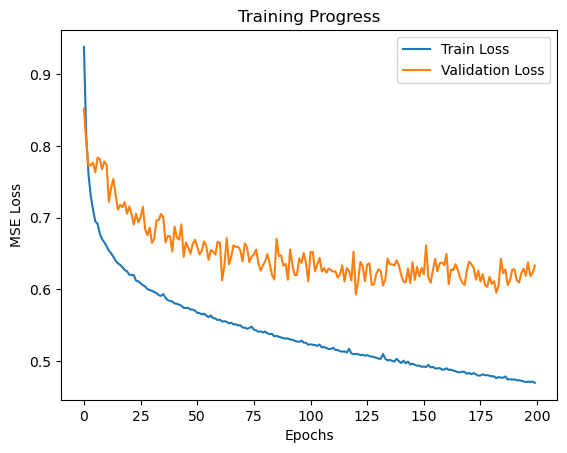

In [45]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training Progress')
plt.show()


In [47]:
model.eval()
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
predictions, actuals = [], []


In [49]:
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).cpu().numpy().flatten()
        predictions.extend(outputs)
        actuals.extend(labels.numpy())


In [51]:
scaler_mean = scaler.mean_[target_col]    # Index 0 for ws3m
scaler_scale = scaler.scale_[target_col]  # Index 0 for ws3m

# Inverse transform predictions and actuals
predictions_orig = (np.array(predictions) * scaler_scale) + scaler_mean
actuals_orig = (np.array(actuals) * scaler_scale) + scaler_mean


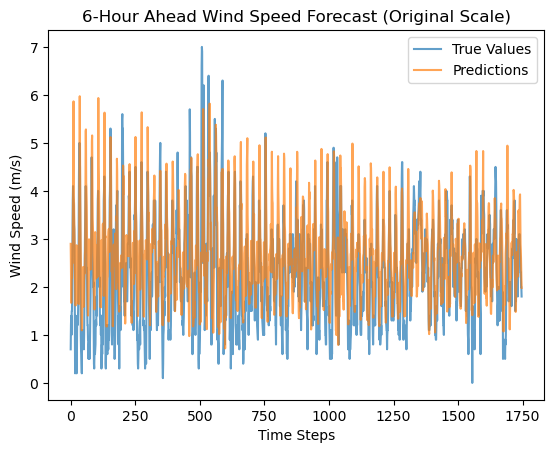

In [57]:

plt.plot(actuals_orig, label='True Values', alpha=0.7)
plt.plot(predictions_orig, label='Predictions', alpha=0.7)
plt.xlabel('Time Steps')
plt.ylabel('Wind Speed (m/s)')
plt.title('6-Hour Ahead Wind Speed Forecast (Original Scale)')
plt.legend()





In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_val = mean_squared_error(actuals_orig, predictions_orig)
mae_val = mean_absolute_error(actuals_orig, predictions_orig)

print(f'Mean Squared Error: {mse_val:.4f} m²/s²')
print(f'Mean Absolute Error: {mae_val:.4f} m/s')
print(f'RMSE: {np.sqrt(mse_val):.4f} m/s')


Mean Squared Error: 0.9402 m²/s²
Mean Absolute Error: 0.7743 m/s
RMSE: 0.9696 m/s
